In [1]:
from gurobipy import Model, GRB, quicksum
import pandas as pd
import numpy as np

In [2]:
# Données
N = 4  # Nombre de SRs
M = 22  # Nombre de bricks


# Read the CSV file 
# ATTENTION : les données sont à adapter en fonction du fichier
bricks_df = pd.read_csv('../data/22x4/bricks_index_values.csv')
distances_df = pd.read_excel('../data/22x4/distances.xlsx', sheet_name='brick-brick', usecols="C:X", skiprows=1)

# Extract bricks and their index values
bricks = bricks_df['brick'].tolist()
workloads = bricks_df['index_value'].tolist() # Index des bricks


In [3]:
print(workloads[:5])

[0.1609, 0.1164, 0.1026, 0.1516, 0.0939]


In [4]:
distances_df.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,0.000000,7.353258,13.208755,16.159669,18.219385,16.683252,14.003832,19.022245,17.447017,28.486721,...,24.528583,24.094136,25.383225,24.293812,23.233883,23.698122,8.475966,13.845739,5.237194,21.120353
1,7.353258,0.000000,6.575409,19.000329,20.060199,19.064367,16.300702,21.588353,21.449886,30.986005,...,25.984799,26.473492,28.221837,27.224160,26.252522,26.271829,8.079431,8.361800,9.146857,17.330058
2,13.208755,6.575409,0.000000,25.293843,26.050850,25.242300,22.536115,27.759038,27.928323,36.986085,...,31.680357,32.498003,34.365455,33.407055,32.472254,32.361721,14.181241,10.961756,15.719574,12.247094
3,16.159669,19.000329,25.293843,0.000000,3.069544,1.219262,2.796319,2.872716,3.799224,12.348279,...,8.819597,7.935320,9.337858,8.289656,7.280000,7.550265,11.126801,17.492090,11.028259,36.120000
4,18.219385,20.060199,26.050850,3.069544,0.000000,1.915646,4.221718,2.354782,6.186857,10.943843,...,6.311022,6.447154,8.403910,7.548649,6.769202,6.346416,11.984824,17.217680,12.986216,37.368839


In [5]:
# Convert distances_df to a distance matrix
distances = distances_df.values.tolist()

In [6]:
print(len(distances))
print(len(distances[0]))
print(distances[14][14])

22
22
0.0


## Bi-objective with moving offices

minimum of total distance and MinMax of workload.

In [29]:
def epsilon_total_dist_workload():

    # Start with epsilon as infinity
    epsilon = np.inf
    non_dominant_solutions = []

    while epsilon > 0:

        # Modèle
        model = Model("Bi-Objective Optimization for minimum of total distance")

        # Variables de décision
        x = model.addVars(N, M, vtype=GRB.BINARY, name="x")  # Assignation des bricks
        c = model.addVars(N, M, vtype=GRB.BINARY, name="c")  # Center bricks pour chaque SR

        # Objectif 1 : Distance totale
        #Z1 = quicksum(distances[i][j] * x[i, j] for i in range(N) for j in range(M))
        Z1 = quicksum(distances[i][j] * x[k, i] * c[k, j] for i in range(M) for j in range (M) for k in range(N))
        # Objectif 2 : Charge de travail maximale
        workload_per_SR = [quicksum(workloads[j] * x[i, j] for j in range(M)) for i in range(N)]
        Z2 = model.addVar(vtype=GRB.CONTINUOUS, name="max_workload")
        model.addConstrs((workload_per_SR[i] <= Z2 for i in range(N)), name="WorkloadMax")

        # Ajout des contraintes
        # 1. Chaque brick est assigné à un représentant
        model.addConstrs((quicksum(x[i, j] for i in range(N)) == 1 for j in range(M)), name="AssignBricks")

        # 2. Charge de travail des SRs dans les bornes
        model.addConstrs((workload_per_SR[i] >= 0.8 for i in range(N)), name="WorkloadMin")
        model.addConstrs((workload_per_SR[i] <= 1.2 for i in range(N)), name="WorkloadMaxBounds")

        # 3. Relation entre x et c (simplifiée ici, à adapter selon les règles de votre problème)
        model.addConstrs((quicksum(c[i, j] for j in range(M)) == 1 for i in range(N)), name="UniqueCenter")

        # Configuration bi-objective (Epsilon-Constraint)
        # Fixer Z2 <= epsilon et minimiser Z1

        model.addConstr(Z2 <= epsilon, name="EpsilonConstraint")
        model.setObjective(Z1, GRB.MINIMIZE)

        # Résolution
        model.optimize()

        # Extraction des résultats
        if model.status == GRB.OPTIMAL:
            print("Distance totale (Z1):", Z1.getValue())
            print("Charge de travail maximale (Z2):", Z2.x)
            this_assignment = model.getAttr("x", x)
            this_centers = model.getAttr("x", c)
            print("Assignments:", this_assignment)
            print("Centers:", this_centers)
            new_epsilon = max([workload_per_SR[i].getValue() for i in range(N)])
            non_dominant_solutions.append((this_assignment, this_centers, new_epsilon, Z1.getValue()))
            epsilon = new_epsilon - 0.01
            
        else:
           break
        
    return non_dominant_solutions


In [30]:
non_dominant_solutions = epsilon_total_dist_workload()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 39 rows, 177 columns and 445 nonzeros
Model fingerprint: 0x4d852965
Model has 1848 quadratic objective terms
Variable types: 1 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 401.0007404
Presolve removed 5 rows and 1 columns
Presolve time: 0.02s
Presolved: 1882 rows, 2024 columns, 5896 nonzeros
Variable types: 0 continuous, 2024 integer (2024 binary)



Root relaxation: objective 0.000000e+00, 106 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   67  401.00074    0.00000   100%     -    0s
H    0     0                     284.1867737    0.00000   100%     -    0s
H    0     0                     149.4816258    0.00000   100%     -    0s
H    0     0                     117.2515302    0.00000   100%     -    0s
     0     0    0.00000    0   73  117.25153    0.00000   100%     -    0s
     0     0   23.50980    0  101  117.25153   23.50980  79.9%     -    0s
     0     0   27.46711    0  103  117.25153   27.46711  76.6%     -    0s
     0     0   27.46711    0  102  117.25153   27.46711  76.6%     -    0s
     0     0   59.81634    0  135  117.25153   59.81634  49.0%     -    0s
     0     0   60.45827    0  166  117.25153   60.45827  48.4%     -    0s
     0   

In [31]:

# Print the results
for assignments, centers, epsilon, total_dist in non_dominant_solutions:
    print(f"Epsilon: {epsilon}, Total Distance: {total_dist}")

Epsilon: 1.1307, Total Distance: 103.56395980541879
Epsilon: 1.1149, Total Distance: 105.05653000684552
Epsilon: 1.0866, Total Distance: 106.59785544391693
Epsilon: 1.0439, Total Distance: 109.3325398215409
Epsilon: 1.0068000000000001, Total Distance: 110.97119752528226


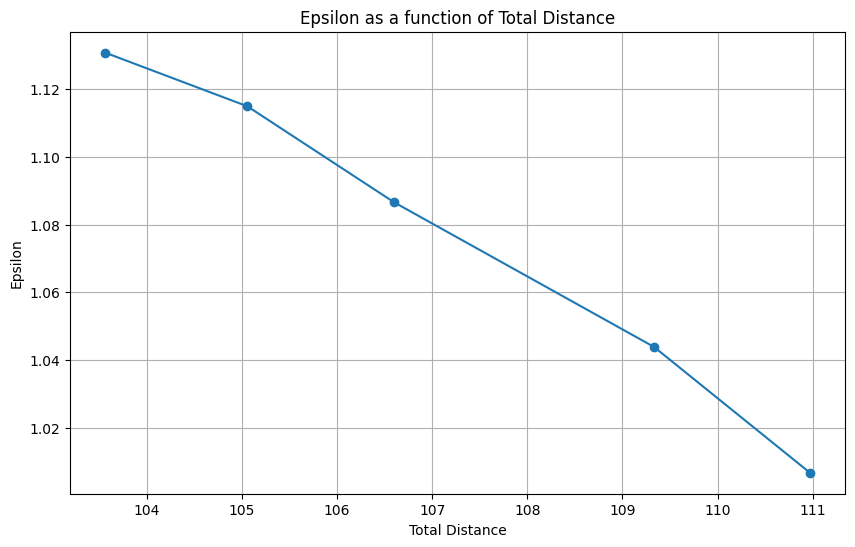

In [32]:
import matplotlib.pyplot as plt

# Extract epsilon and total_dist values from non_dominant_solutions
epsilon_values = [solution[2] for solution in non_dominant_solutions]
total_dist_values = [solution[3] for solution in non_dominant_solutions]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(total_dist_values, epsilon_values, marker='o')
plt.xlabel('Total Distance')
plt.ylabel('Epsilon')
plt.title('Epsilon as a function of Total Distance')
plt.grid(True)
plt.show()
    


# Tri-objectif

Minimisons le nombre de variations des localisation de bureaux

In [34]:
initial_bricks = {
    0: {'center_brick': 3, 'assigned_bricks': [3, 4, 5, 6, 7, 14]},
    1: {'center_brick': 13, 'assigned_bricks': [9, 10, 11, 12, 13]},
    2: {'center_brick': 15, 'assigned_bricks': [8, 15, 16, 17]},
    3: {'center_brick': 21, 'assigned_bricks': [0, 1, 2, 18, 19, 20, 21]}
}

initial_centers = np.zeros((N, M))

for sr, data in initial_bricks.items():
    center_brick = data['center_brick']
    assigned_bricks = data['assigned_bricks']
    initial_centers[sr][center_brick] = 1

In [65]:
def three_objective_optimization(total_change):

    # Valeurs initiales
    epsilon = np.inf  # Nombre maximum de SRs
    non_dominant_tri_solutions = []

    while epsilon >= 0:
        # Modèle
        model = Model("Three-Objective Optimization")

        # Variables de décision
        x = model.addVars(N, M, vtype=GRB.BINARY, name="x")  # Assignation des bricks
        c = model.addVars(N, M, vtype=GRB.BINARY, name="c")  # Center bricks
        
        # Ajout
        y = model.addVars(N, vtype=GRB.BINARY, name="y")     # Relocalisation des bureaux

        # Objectif 1 : Distance totale
        Z1 = quicksum(distances[i][j] * x[k, i] * c[k, j] for i in range(M) for j in range (M) for k in range(N))

        # Objectif 2 : Charge de travail maximale
        workload_per_SR = [quicksum(workloads[j] * x[i, j] for j in range(M)) for i in range(N)]
        Z2 = model.addVar(vtype=GRB.CONTINUOUS, name="max_workload")
        model.addConstrs((workload_per_SR[i] <= Z2 for i in range(N)), name="WorkloadMax")

        # Objectif 3 : Disruption (Relocalisation des bureaux)
        Z3 = quicksum(y[i] for i in range(N))
        model.addConstr(Z3 == total_change)

        # Contraintes de relocalisationfor i in range(N):
        for i in range(N):
            for j in range(M):
                model.addConstr(y[i] >= c[i, j] - initial_centers[i][j])  # Si c[i, j] diffère de initial_centers[i][j], y[i] = 1
                model.addConstr(y[i] >= initial_centers[i][j] - c[i, j])  # Pareil dans l'autre sens


        # Contraintes d'assignation et de charge de travail
        model.addConstrs((quicksum(x[i, j] for i in range(N)) == 1 for j in range(M)), name="AssignBricks")
        model.addConstrs((workload_per_SR[i] >= 0.8 for i in range(N)), name="WorkloadMin")
        model.addConstrs((workload_per_SR[i] <= 1.2 for i in range(N)), name="WorkloadMaxBounds")
        model.addConstrs((quicksum(c[i, j] for j in range(M)) == 1 for i in range(N)), name="UniqueCenter")

        # Epsilon-Constraint sur la disruption
        model.addConstr(Z2 <= epsilon, name="EpsilonConstraint")

        # Minimisation de la distance totale
        model.setObjective(Z1, GRB.MINIMIZE)

        # Résolution
        model.optimize()

        # Extraction des résultats
        if model.status == GRB.OPTIMAL:
            total_distance = Z1.getValue()
            max_workload = Z2.x

            non_dominant_tri_solutions.append((total_distance,max_workload))

            new_epsilon = max([workload_per_SR[i].getValue() for i in range(N)])
            epsilon = new_epsilon - 0.01
        else:
            break

    return non_dominant_tri_solutions


In [ ]:
non_dominant_sols = []

for i in range(N+1):
    non_dominant_sols.append((three_objective_optimization(i), i))

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 216 rows, 181 columns and 801 nonzeros
Model fingerprint: 0x60231114
Model has 1848 quadratic objective terms
Variable types: 1 continuous, 180 integer (180 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+100]


         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 334.0354587
Presolve removed 186 rows and 93 columns
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.488142e+02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  148.81424    0    6  334.03546  148.81424  55.4%     -    0s
H    0     0                     180.9624934  148.81424  17.8%     -    0s
H    0     0                     154.6152215  148.81424  3.75%     -    0s
     0     0  148.81424    0    6  154.61522  148.81424  3.75%     -    0s

Explored 1 nodes (25 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 20 (of 20 available processors)

Solution count 3: 

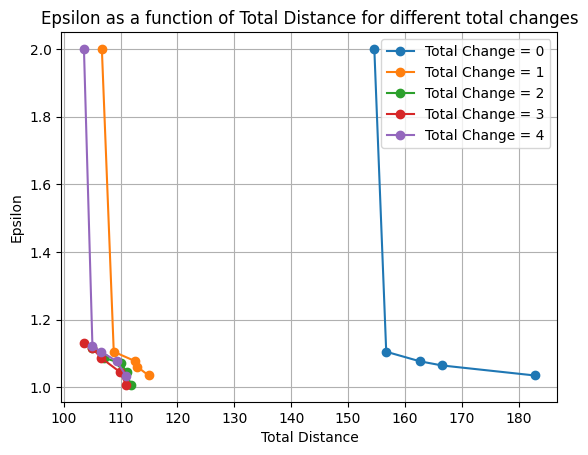

In [69]:
import matplotlib.pyplot as plt

# Extraction des valeurs et tracé
for solutions, total_change in non_dominant_sols[:5]:
    total_dist_values = [solution[0] for solution in solutions]
    epsilon_values = [solution[1] for solution in solutions]

    # Tracé
    plt.plot(total_dist_values, epsilon_values, marker='o', label=f'Total Change = {total_change}')

# Ajout des labels et autres éléments
plt.xlabel('Total Distance')
plt.ylabel('Epsilon')
plt.title('Epsilon as a function of Total Distance for different total changes')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
for solutions, total_change in non_dominant_sols:
    epsilon_values = [solution[1] for solution in solutions]
    total_dist_values = [solution[0] for solution in solutions]
    print(f"Total Change: {total_change}, Epsilon: {epsilon_values}, Total Distance: {total_dist_values}")

Total Change: 0, Epsilon: [2.0, 1.1049, 1.0766, 1.0642999999999998, 1.0347], Total Distance: [154.615221487796, 156.70732400284993, 162.6305634151781, 166.53355458416658, 182.83943560747628]
Total Change: 1, Epsilon: [2.0, 1.1049, 1.0766, 1.0606, 1.0347], Total Distance: [106.7132327169449, 108.80533523199884, 112.62476118814021, 112.916199755518, 114.94458093965926]
Total Change: 2, Epsilon: [1.1149, 1.0866, 1.0706, 1.0439, 1.0068000000000001], Total Distance: [105.05653000684552, 107.14863252189946, 110.1308979528074, 111.07508878302883, 111.7905994757414]
Total Change: 3, Epsilon: [1.1307, 1.1149, 1.0866, 1.0439, 1.0068000000000001], Total Distance: [103.62671041188815, 105.05653000684552, 106.59785544391693, 109.97316061826024, 110.97119752528226]
Total Change: 4, Epsilon: [2.0, 1.1207, 1.1049, 1.0766, 1.0339], Total Distance: [103.56395980541879, 105.05653000684552, 106.59785544391693, 109.3325398215409, 110.97119752528226]
Total Change: 5, Epsilon: [], Total Distance: []
Total Ch

In [70]:
non_dom_sols = non_dominant_sols[:5]
# Create a DataFrame from the non-dominant solutions
df = pd.DataFrame([(sol[0], sol[1], total_change) for solutions, total_change in non_dom_sols for sol in solutions],
                  columns=['distance', 'max_workload', '#changed offices'])


In [71]:
df.head()

,distance,max_workload,#changed offices
0,154.615221,2.0000,0
1,156.707324,1.1049,0
2,162.630563,1.0766,0
3,166.533555,1.0643,0
4,182.839436,1.0347,0


In [72]:

# Save the DataFrame to a CSV file
df.to_csv('non_dominant_solutions_tri_objectives.csv', index=False)